In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import rpy2.robjects as robj
import pyreadr
from easydict import EasyDict as edict
from tqdm import tqdm_notebook as tqdm
import sys
import time as Time
import pickle
from scipy.io import loadmat
from scipy.signal import decimate, detrend
import seaborn as sns
%matplotlib inline

In [2]:
sys.path.append("/home/huaqingj/MyResearch/dynamicR2py")
from utils import *

In [3]:
MEG = loadmat("./data/subj2.mat")["DK_timecourse"]

In [4]:
#Rate when doing decimate 
rate = 10 
#MEG = detrend(MEG) # The data are already detrended
MEG = decimate(MEG, q=rate)

## Detection when r=8

In [5]:
kappa = 2.95
r = 8
Lmin = 60
# Down sample rate when estimating A matrix
downrate = 20 
MaxM = 19
lamb = 1e-4
fct = 0.5
d, n = MEG.shape
time = np.linspace(0, 2, n)

In [7]:
t0 = Time()
dXmat, Xmat = GetBsplienEst(MEG, time, lamb=lamb)
Amat = GetAmat(dXmat, Xmat, time, downrate, fct=fct)
midRes = GetNewEst(dXmat, Xmat, Amat, r=r, is_full=True)
ndXmat, nXmat = midRes.ndXmat, midRes.nXmat
finalRes = EGenDy(ndXmat, nXmat, kappa=kappa, Lmin=Lmin, MaxM=MaxM, diag=True)
tc = Time()

In [8]:
MEG2ResRank8 = edict()
MEG2ResRank8.PostMEG = MEG
MEG2ResRank8.midRes = midRes
MEG2ResRank8.finalRes = finalRes
MEG2ResRank8.Amat = Amat
MEG2ResRank8.dXmat = dXmat
MEG2ResRank8.Xmat = Xmat
paras = {"kappa":kappa, "Lmin":Lmin, "r":r, "downrate":downrate, "MaxM":MaxM, "lamb":lamb, "rate":rate}
MEG2ResRank8.paras = paras

In [9]:
with open("./results/MEG2ResRank8.pkl", "wb") as f:
    pickle.dump(MEG2ResRank8, f)

In [31]:
with open("./results/MEG2ResRank8.pkl", "rb") as f:
    MEG2ResRank8 = pickle.load(f)

In [32]:
MEG2ResRank8.finalRes.chgMat[11, :12]

array([ 192.,  576.,  851., 1248., 1514., 1761., 2026., 2244., 2507.,
       2752., 3062., 3336.])

### Draw the change points curve

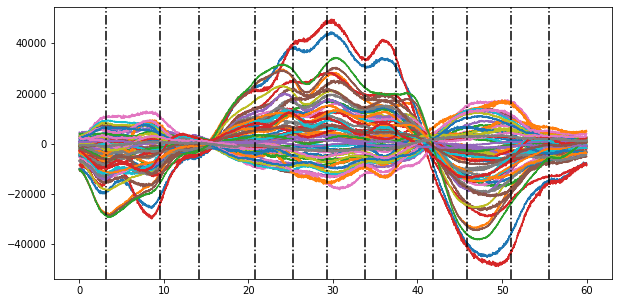

In [33]:
plt.figure(figsize=[10, 5])
ptime = np.linspace(0, 60, n)
for i in range(d):
    plt.plot(ptime, MEG[i, :], "-")
#for ecpt in MEG2ResRank8.finalRes.mbic_ecpts:
for ecpt in MEG2ResRank8.finalRes.chgMat[11, :12]: 
    plt.axvline(ecpt/60, color="black", linestyle="-.")

### Plot the Reconstructed Curve

In [34]:
finalRes = MEG2ResRank8.finalRes
midRes = MEG2ResRank8.midRes
t0 = Time()
tStep = np.diff(time)[0]
ecpts = finalRes.mbic_ecpts
ndXmat = midRes.ndXmat
nXmat = midRes.nXmat
kpidxs = midRes.kpidxs
eigVecs = midRes.eigVecs
RecRes = ReconXmat(MEG2ResRank8.finalRes.chgMat[11, :12], ndXmat, nXmat, kpidxs, eigVecs, MEG, tStep, r=8, is_full=True) 
RecMEG = RecRes.EstXmatReal
tc = Time()
print(f"The consumed time is {tc-t0:.2f}s.")

The consumed time is 26.20s.


In [39]:
ndXmat[6, :]

array([-13018.32582538, -13016.67809081, -13015.71419536, ...,
        -3345.16997436,  -3344.0868268 ,  -3342.64362032])

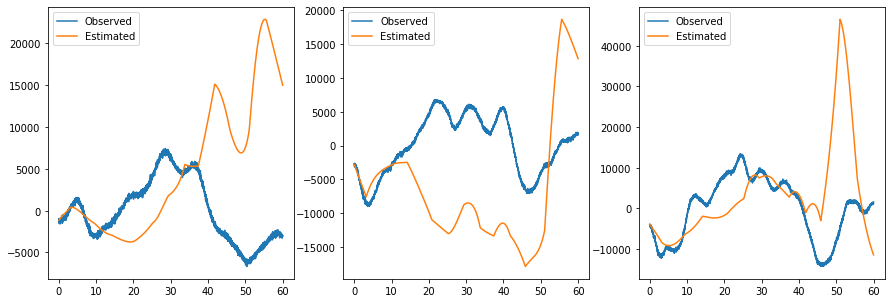

In [15]:
ptime = np.linspace(0, 60, n)
plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
plt.plot(ptime, MEG[45, :], label="Observed")
plt.plot(ptime, RecMEG[45, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 2)
plt.plot(ptime, MEG[43, :], label="Observed")
plt.plot(ptime, RecMEG[43, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ptime, MEG[59, :], label="Observed")
plt.plot(ptime, RecMEG[59, :], label="Estimated")
_ = plt.legend()

In [24]:
freq = 60 
ReLamMs = RecRes.LamMs.real*freq/30 
ImLamMs = RecRes.LamMs.imag*freq /(30*2*np.pi)

In [25]:
linestyles = [  ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))] 
cols = sns.color_palette("Paired", 6)
#cols = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

IndexError: list index out of range

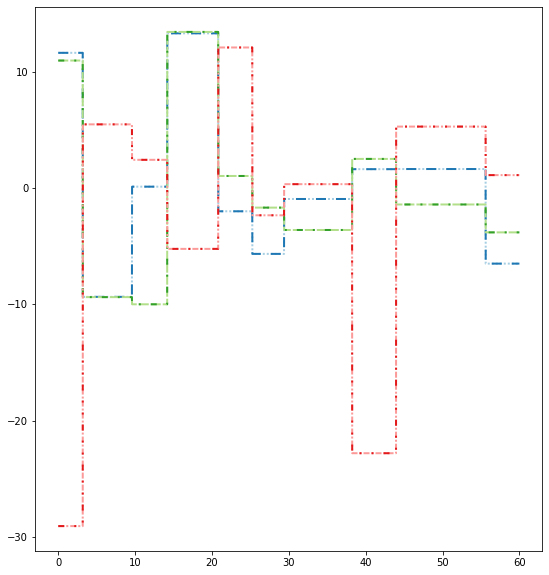

In [26]:
plt.figure(figsize=[20,10])

plt.subplot(121)
for i in range(ReLamMs.shape[0]):
    plt.plot(ptime, ReLamMs[i, :], label=f"Lam {i+1}", linestyle=linestyles[i+1][-1], color=cols[i], linewidth=2)
plt.ylim([-15, 40])
plt.ylabel("change of growth/decay constant")
plt.xlabel("time")
_ = plt.legend()

plt.subplot(122)
for i in range(ReLamMs.shape[0]):
    plt.plot(ptime, ImLamMs[i, :], label=f"Lam {i+1}", linestyle=linestyles[i][-1], color=cols[i], linewidth=2)
plt.ylim([-10, 15])
plt.ylabel("change of growth/decay constant")
plt.xlabel("time")
_ = plt.legend()

### Kappa tuning

In [35]:
kappas = np.linspace(2.5, 3, 100)

In [36]:
U0 = MEG2ResRank8.finalRes.U0

In [37]:
U0s = []
for kappac in kappas:
    U0s.append(U0 + 2*r*np.log(n)**kappac* (np.arange(1, MaxM+2)))
U0s = np.array(U0s)

In [38]:
numchgs = U0s.argmin(axis=1)

In [55]:
midRes.keys()

dict_keys(['ndXmat', 'nXmat', 'kpidxs', 'eigVecs', 'eigVals'])

In [56]:
midRes.eigVals

array([-4.63591731e+01+6.07724870e+02j, -4.63591731e+01-6.07724870e+02j,
        6.45404636e+01+4.42448783e+02j,  6.45404636e+01-4.42448783e+02j,
       -1.15670877e+02+2.12806838e+02j, -1.15670877e+02-2.12806838e+02j,
        2.64851590e+01+0.00000000e+00j, -4.73563725e+00+1.07941381e-01j,
       -4.73563725e+00-1.07941381e-01j,  1.33989665e+00+2.40500604e+00j,
        1.33989665e+00-2.40500604e+00j, -1.44699258e-01+1.62377310e+00j,
       -1.44699258e-01-1.62377310e+00j,  6.08906915e-01+4.95176299e-01j,
        6.08906915e-01-4.95176299e-01j, -4.32084580e-01+0.00000000e+00j,
        1.45712343e-02+3.06864886e-01j,  1.45712343e-02-3.06864886e-01j,
       -1.01377660e-01+0.00000000e+00j,  2.96881665e-03+6.97536770e-02j,
        2.96881665e-03-6.97536770e-02j, -3.02013644e-02+5.46032214e-02j,
       -3.02013644e-02-5.46032214e-02j,  6.08587231e-02+0.00000000e+00j,
        1.07716098e-02+4.36200171e-02j,  1.07716098e-02-4.36200171e-02j,
        3.92499015e-02+0.00000000e+00j, -1.39272379

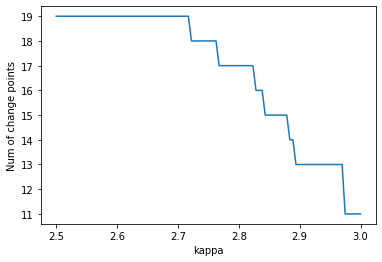

In [39]:
plt.plot(kappas, numchgs)
plt.ylabel("Num of change points")
_ = plt.xlabel("kappa")

In [40]:
numchgs

array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16,
       15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 11, 11, 11, 11, 11])

In [29]:
kappas[numchgs==11]

array([2.65656566, 2.66161616])

## Change the rank of Amat  when rank=4

In [16]:
kappa = 2.95
r = 4
Lmin = 60
# Down sample rate when estimating A matrix
downrate = 20 
MaxM = 19
lamb = 1e-4
fct = 0.5
d, n = MEG.shape
time = np.linspace(0, 2, n)

paras = {"kappa":kappa, "Lmin":Lmin, "r":r, "downrate":downrate, "MaxM":MaxM, "lamb":lamb, "rate":rate}

In [17]:
print(paras)

{'kappa': 2.95, 'Lmin': 60, 'r': 4, 'downrate': 20, 'MaxM': 19, 'lamb': 0.0001, 'rate': 10}


In [17]:
t0 = Time()
dXmat, Xmat = GetBsplienEst(MEG, time, lamb=lamb)
Amat = GetAmat(dXmat, Xmat, time, downrate, fct=fct)
midRes = GetNewEst(dXmat, Xmat, Amat, r=r, is_full=True)
ndXmat, nXmat = midRes.ndXmat, midRes.nXmat
finalRes = EGenDy(ndXmat, nXmat, kappa=kappa, Lmin=Lmin, MaxM=MaxM, diag=True)
tc = Time()

In [19]:
MEG2ResRank4 = edict()
MEG2ResRank4.PostMEG = MEG
MEG2ResRank4.midRes = midRes
MEG2ResRank4.finalRes = finalRes
MEG2ResRank4.Amat = Amat
MEG2ResRank4.dXmat = dXmat
MEG2ResRank4.Xmat = Xmat
MEG2ResRank4.paras = paras

In [20]:
with open("./results/MEG2ResRank4.pkl", "wb") as f:
    pickle.dump(MEG2ResRank4, f)

In [18]:
with open("./results/MEG2ResRank4.pkl", "rb") as f:
    MEG2ResRank4 = pickle.load(f)

In [26]:
finalRes = MEG2ResRank4.finalRes
midRes = MEG2ResRank4.midRes
t0 = Time()
tStep = np.diff(time)[0]
ecpts = finalRes.mbic_ecpts
ndXmat = midRes.ndXmat
nXmat = midRes.nXmat
kpidxs = midRes.kpidxs
eigVecs = midRes.eigVecs
RecRes = ReconXmat(MEG2ResRank4.finalRes.chgMat[10, :11], ndXmat, nXmat, kpidxs, eigVecs, MEG, tStep, r=r, is_full=True) 
RecMEG = RecRes.EstXmatReal
tc = Time()
print(f"The consumed time is {tc-t0:.2f}s.")

The consumed time is 26.37s.


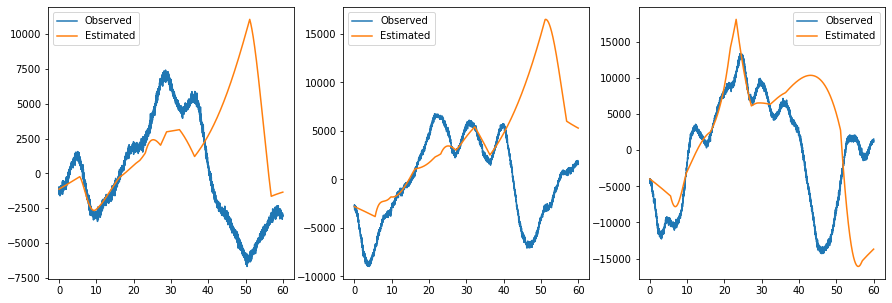

In [27]:
ptime = np.linspace(0, 60, n)
plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
plt.plot(ptime, MEG[45, :], label="Observed")
plt.plot(ptime, RecMEG[45, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 2)
plt.plot(ptime, MEG[43, :], label="Observed")
plt.plot(ptime, RecMEG[43, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ptime, MEG[59, :], label="Observed")
plt.plot(ptime, RecMEG[59, :], label="Estimated")
_ = plt.legend()

## Change the rank of Amat  when rank=6

In [41]:
kappa = 2.95
r = 4
Lmin = 60
# Down sample rate when estimating A matrix
downrate = 20 
MaxM = 19
lamb = 1e-4
fct = 0.5
d, n = MEG.shape
time = np.linspace(0, 2, n)

paras = {"kappa":kappa, "Lmin":Lmin, "r":r, "downrate":downrate, "MaxM":MaxM, "lamb":lamb, "rate":rate}

In [42]:
print(paras)

{'kappa': 2.95, 'Lmin': 60, 'r': 4, 'downrate': 20, 'MaxM': 19, 'lamb': 0.0001, 'rate': 10}


In [7]:
t0 = Time()
dXmat, Xmat = GetBsplienEst(MEG, time, lamb=lamb)
Amat = GetAmat(dXmat, Xmat, time, downrate, fct=fct)
midRes = GetNewEst(dXmat, Xmat, Amat, r=r, is_full=True)
ndXmat, nXmat = midRes.ndXmat, midRes.nXmat
finalRes = EGenDy(ndXmat, nXmat, kappa=kappa, Lmin=Lmin, MaxM=MaxM, diag=True)
tc = Time()

In [8]:
MEG2ResRank6 = edict()
MEG2ResRank6.PostMEG = MEG
MEG2ResRank6.midRes = midRes
MEG2ResRank6.finalRes = finalRes
MEG2ResRank6.Amat = Amat
MEG2ResRank6.dXmat = dXmat
MEG2ResRank6.Xmat = Xmat
MEG2ResRank6.paras = paras

In [9]:
with open("./results/MEG2ResRank6.pkl", "wb") as f:
    pickle.dump(MEG2ResRank6, f)

In [40]:
with open("./results/MEG2ResRank6.pkl", "rb") as f:
    MEG2ResRank6 = pickle.load(f)

In [43]:
finalRes = MEG2ResRank6.finalRes
midRes = MEG2ResRank6.midRes
t0 = Time()
tStep = np.diff(time)[0]
ecpts = finalRes.mbic_ecpts
ndXmat = midRes.ndXmat
nXmat = midRes.nXmat
kpidxs = midRes.kpidxs
eigVecs = midRes.eigVecs
RecRes = ReconXmat(MEG2ResRank6.finalRes.chgMat[11, :12], ndXmat, nXmat, kpidxs, eigVecs, MEG, tStep, r=r, is_full=True) 
RecMEG = RecRes.EstXmatReal
tc = Time()
print(f"The consumed time is {tc-t0:.2f}s.")

The consumed time is 26.46s.


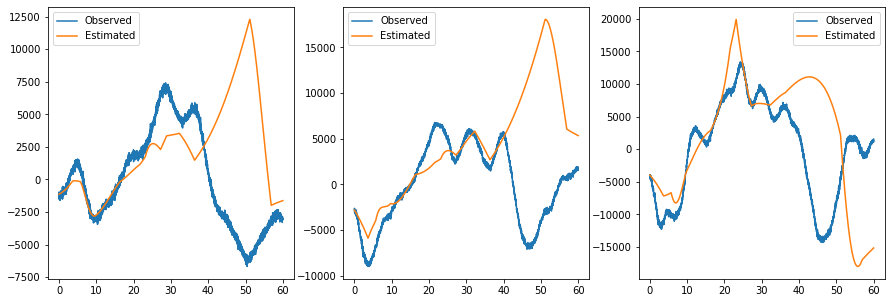

In [44]:
ptime = np.linspace(0, 60, n)
plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
plt.plot(ptime, MEG[45, :], label="Observed")
plt.plot(ptime, RecMEG[45, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 2)
plt.plot(ptime, MEG[43, :], label="Observed")
plt.plot(ptime, RecMEG[43, :], label="Estimated")
_ = plt.legend()

plt.subplot(1, 3, 3)
plt.plot(ptime, MEG[59, :], label="Observed")
plt.plot(ptime, RecMEG[59, :], label="Estimated")
_ = plt.legend()

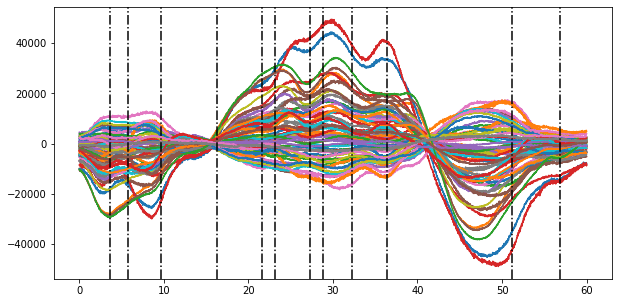

In [45]:
plt.figure(figsize=[10, 5])
ptime = np.linspace(0, 60, n)
for i in range(d):
    plt.plot(ptime, MEG[i, :], "-")
for ecpt in MEG2ResRank6.finalRes.chgMat[11, :12]: 
    plt.axvline(ecpt/60, color="black", linestyle="-.")